<a href="https://colab.research.google.com/github/TerpstraS/GEBM_nadcom23/blob/main/GEBM_nadcom23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

plt.rc("font", family="serif", size=12.)
plt.rc("savefig", dpi=300, format="png")
plt.rc("legend", loc="best", fontsize="x-small", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=1.4, markersize=7, markeredgewidth=1.5)
plt.rc("axes.spines", top=False, right=False)

### Model

In [ ]:
class GEBM:
    def __init__(
        self, tau_a=0, tau_NV=0, nu_NV=0, mu_0=50 * (3600*24*365)**3, rho_0=10, rho_func=None,
        K_eps=0.5
    ):

        # constants
        self.C = 5e8 * (3600*24*365)**2
        self.Q_0 = 341.3 * (3600*24*365)**3
        self.sigma = 5.67e-8 * (3600*24*365)**3
        self.alpha1 = 0.7
        self.alpha2 = 0.289
        self.T_alpha = 274.5
        self.K_alpha = 0.1
        self.eps1 = 0.5
        self.eps2 = 0.41
        self.T_eps = 288
        self.K_eps = K_eps
        self.A0 = 5.35 * (3600*24*365)**3

        # forcing parameters
        self.mu_0 = mu_0
        self.rho_0 = rho_0
        self.rho_func = rho_func # custom function radiative forcing, takes t and rho_0 as parameters

        # parameters
        self.tau_a = tau_a
        self.tau_NV = tau_NV
        self.nu_NV = nu_NV

        # solutions
        self.sol = None
        self.t = None
        self.x = None
        self.y = None
        self.z = None
        self.alpha = None

        # initial condition
        # this is changed when using equilibriate()
        self.y0 = [255, 10, 10, 5, 0.33]

    def dGEBM(self, t, z):
        T, xx, yy, zz, alpha = z

        # calculate albedo if it is instantanuous
        if self.tau_a == 0:
            alpha = self.alpha_0(T)
            dalpha = 0
        else:
            dalpha = (1 / self.tau_a) * (self.alpha_0(T) - alpha)

        # calculate emissivity
        epsilon = self.eps(T)

        # calculate radiative forcing
        # if no custom radiative function, use constant forcing
        if self.rho_func is None:
            rho = self.rho_0
        else:
            # assume parameters are t and rho_0
            rho = self.rho_func(t, self.rho_0)

        mu = self.mu_0 + self.A0 * np.log(rho / self.rho_0)

        if self.tau_NV == 0 or self.nu_NV == 0:
            dx = 0
            dy = 0
            dz = 0
            mu_NV = 0
        else:
            dx = 1 / self.tau_NV * (10 * (yy - xx))
            dy = 1 / self.tau_NV * (xx * (28 - zz) - yy)
            dz = 1 / self.tau_NV * (xx * yy - (8/3) * zz)
            mu_NV = self.nu_NV * np.sin(np.pi * xx / 20)

        # alpha = 0.3

        dT = (1/self.C) * (self.Q_0 * (1 - alpha) - epsilon * self.sigma * T**4 + mu + mu_NV)

        return [dT, dx, dy, dz, dalpha]

    def alpha_0(self, T):
        return self.alpha1 + (self.alpha2-self.alpha1) * (1 + np.tanh(self.K_alpha * (T - self.T_alpha))) / 2

    def eps(self, T):
        return self.eps1 + (self.eps2-self.eps1) * (1 + np.tanh(self.K_eps * (T - self.T_eps))) / 2

    def solve(self, t_end=100, y0=None):
        t_span = [0, t_end]
        t_eval = np.linspace(t_span[0], t_span[1], 5001)

        if y0 is None:
            y0 = self.y0
        sol = solve_ivp(
            self.dGEBM, t_span, y0, t_eval=t_eval,
            args=(),
            rtol=10e-7, atol=10e-8
        )

        self.sol = sol
        self.t = sol.t
        self.T = sol.y[0]
        self.x = sol.y[1]
        self.y = sol.y[2]
        self.z = sol.y[3]
        self.alpha = sol.y[4]

        return sol

    def set_equilibrium(self, t_end=1000, y0=None):
        t_span = [0, t_end]

        if y0 is None:
            y0 = self.y0
        sol = solve_ivp(
            self.dGEBM, t_span, y0,
            args=(),
            rtol=10e-7, atol=10e-8
        )

        self.y0 = sol.y[:, -1]

    def plot_T(self, xlim=None, ylim=None):

        if self.sol is None:
            return

        fig, ax = plt.subplots(tight_layout=True)
        ax.plot(self.t, self.T)
        ax.set_xlabel("time (years)")
        ax.set_ylabel("T (Kelvin)")

        # xlim and ylime should be tuples / lists / array of length 2: e.g. xlim = (10, 100)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])

    def plot_T_alpha(self, xlim=None, ylim=None):

        if self.sol is None:
            return

        fig, ax = plt.subplots(tight_layout=True)
        ax.plot(self.T, self.alpha)
        ax.set_xlabel("T (Kelvin)")
        ax.set_ylabel("$\\alpha$")

        # xlim and ylime should be tuples / lists / array of length 2: e.g. xlim = (10, 100)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])

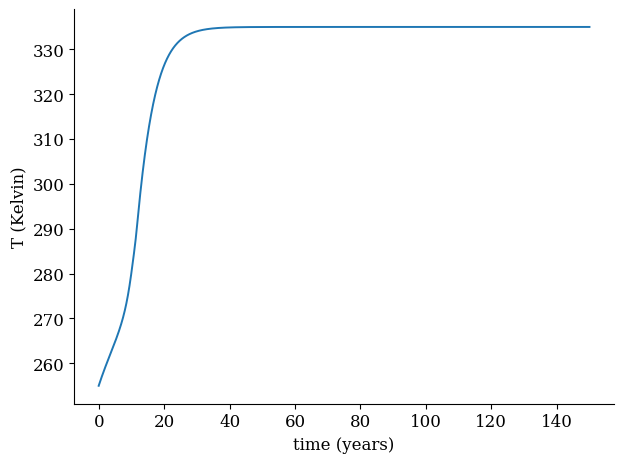

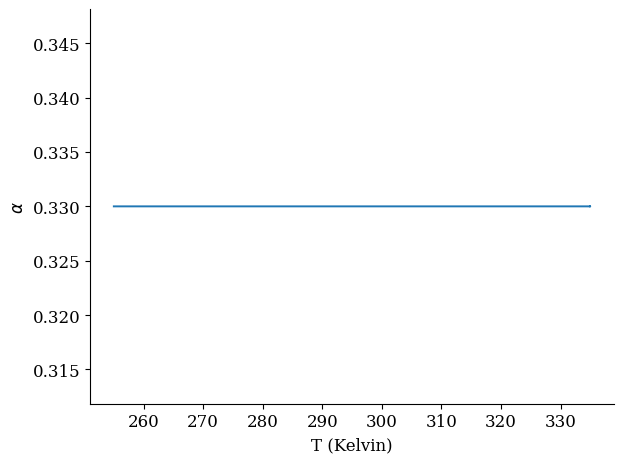

In [ ]:
### usage
# Create model with a given scenario (chaos or not / timescales / forcing parameters)
model = GEBM(tau_a=0, tau_NV=0, nu_NV=0, mu_0=50*(3600*24*365)**3, rho_0=10)

# solve model and plot trajectory
model.solve(t_end=150)
model.plot_T()
model.plot_T_alpha()

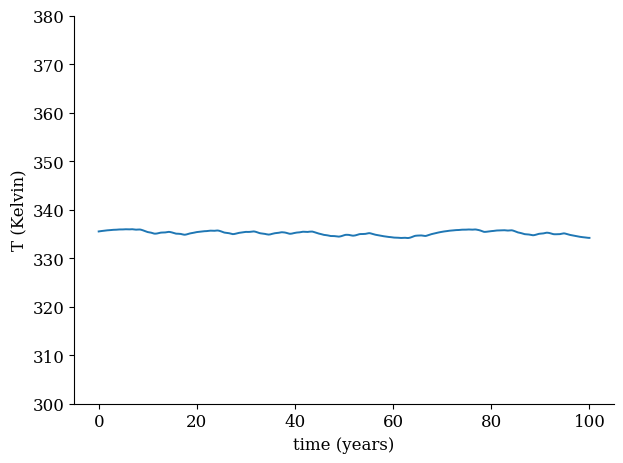

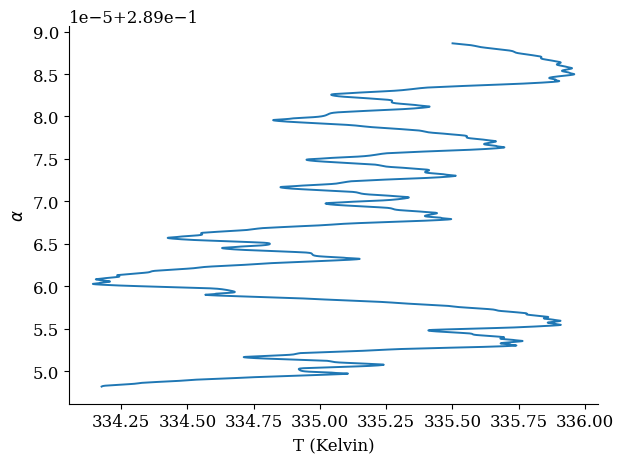

In [ ]:
# usage with custom radiative forcing function (has to take t, rho_0 as parameters)
# and first setting y0 to equilibrium before solving the model
rho_func = lambda t, rho_0: rho_0
tau_a =  5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5 * (3600*24*365)**3
model = GEBM(tau_a=tau_a, tau_NV=tau_NV, nu_NV=nu_NV, mu_0=50*(3600*24*365)**3, rho_0=10, rho_func=rho_func)
model.set_equilibrium()
model.solve()
model.plot_T(ylim=(300, 380))
model.plot_T_alpha()

## Old code

### Constants

In [ ]:
C = 5e8 * (3600*24*365)**2
Q_0 = 341.3 * (3600*24*365)**3
sigma = 5.67e-8 * (3600*24*365)**3
alpha1 = 0.7
alpha2 = 0.289
T_alpha = 274.5
K_alpha = 0.1
eps1 = 0.5
eps2 = 0.41
T_eps = 288
K_eps = 0.5
A0 = 5.35 * (3600*24*365)**3

In [ ]:
# A
tau_a = 0
tau_NV = 0
nu_NV = 0

In [ ]:
# B
tau_a = 0
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5

In [ ]:
# C
tau_a =  5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 2e-2 * (3600*24*365)**3

In [ ]:
#D
K_eps = 0.1
tau_a = 5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 2e-2 * (3600*24*365)**3

### ODE definition

In [ ]:
def GEBM(t, z, mu_0, rho_0, tau_a, tau_NV, nu_NV):
    T, xx, yy, zz, alpha = z

    # calculate albedo if it is instantanuous
    if tau_a == 0:
        alpha = alpha_0(T, alpha1, alpha2, K_alpha, T_alpha)
        dalpha = 0
    else:
        dalpha = (1 / tau_a) * (alpha_0(T, alpha1, alpha2, K_alpha, T_alpha) - alpha)

    # calculate emissivity
    epsilon = eps(T, eps1, eps2, K_eps, T_eps)

    # calculate radiative forcing
    rho = rho_t(t, rho_0)
    mu = mu_0 + A0 * np.log(rho / rho_0)

    if tau_NV == 0 or nu_NV == 0:
        dx = 0
        dy = 0
        dz = 0
        mu_NV = 0
    else:
        dx = 1 / tau_NV * (10 * (yy - xx))
        dy = 1 / tau_NV * (xx * (28 - zz) - yy)
        dz = 1 / tau_NV * (xx * yy - (8/3) * zz)
        mu_NV = nu_NV * np.sin(np.pi * xx / 20)

    # alpha = 0.3

    dT = (1/C) * (Q_0 * (1 - alpha) - epsilon * sigma * T**4 + mu + mu_NV)

    return [dT, dx, dy, dz, dalpha]

In [ ]:
def alpha_0(T, alpha1, alpha2, K_alpha, T_alpha):
    return alpha1 + (alpha2-alpha1) * (1 + np.tanh(K_alpha * (T - T_alpha))) / 2

def eps(T, eps1, eps2, K_eps, T_eps):
    return eps1 + (eps2-eps1) * (1 + np.tanh(K_eps * (T - T_eps))) / 2

def rho_t(t, rho_0):
    return rho_0

In [ ]:
def solve_GEBM(mu_0, rho_0, tau_a, tau_NV, nu_NV, t_end=100):
    t_span = [0, t_end]
    t_eval = np.linspace(t_span[0], t_span[1], 5001)

    y0 = [250, -30, 10, -10, 0.33]

    sol = solve_ivp(
        GEBM, t_span, y0, t_eval=t_eval,
        args=(mu_0, rho_0, tau_a, tau_NV, nu_NV),
        rtol=10e-9, atol=10e-9
    )

    return sol

In [ ]:
mu_0 = -250 * (3600*24*365)**3
rho_0 = 10

# A
tau_a = 0
tau_NV = 0
nu_nv = 0

sol1 = solve_GEBM(mu_0, rho_0, tau_a, tau_NV, nu_NV, t_end=300)

# B
tau_a =  0
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5 * (3600*24*365)**3

sol2 = solve_GEBM(mu_0, rho_0, tau_a, tau_NV, nu_NV, t_end=300)

# C
tau_a =  5e9 / (3600*24*365)
tau_NV = 6e7 / (3600*24*365)
nu_NV = 5 * (3600*24*365)**3 # 2e-2 * (3600*24*365)**3

sol3 = solve_GEBM(mu_0, rho_0, tau_a, tau_NV, nu_NV, t_end=300)


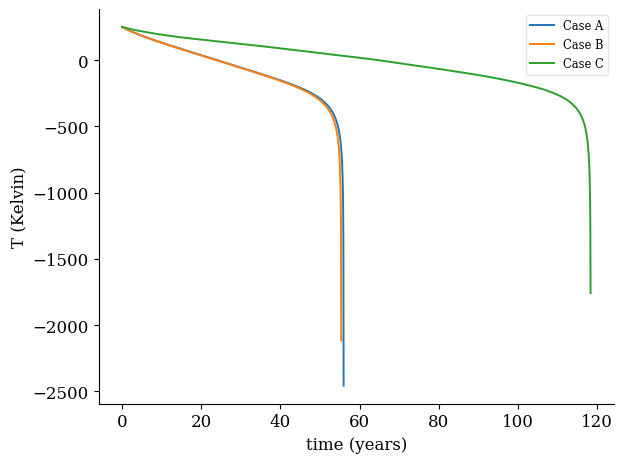

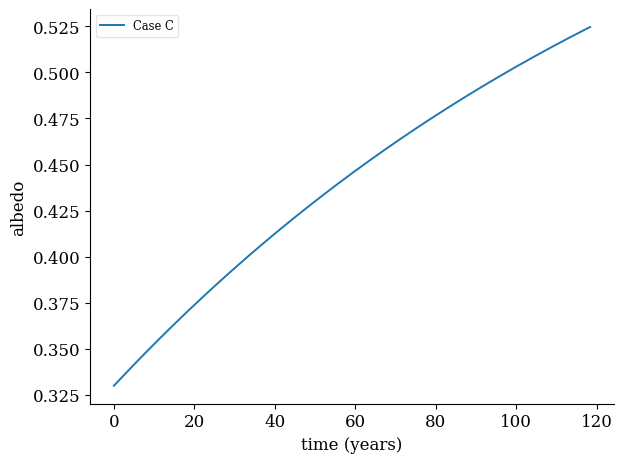

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(sol1.t, sol1.y[0], label="Case A")
ax.plot(sol2.t, sol2.y[0], label="Case B")
ax.plot(sol3.t, sol3.y[0], label="Case C")
ax.set_xlabel("time (years)")
ax.set_ylabel("T (Kelvin)")
ax.legend()

fig, ax = plt.subplots(tight_layout=True)
ax.plot(sol3.t, sol3.y[4], label="Case C")
ax.set_xlabel("time (years)")
ax.set_ylabel("albedo")
ax.legend()

# fig, ax = plt.subplots(tight_layout=True)
# ax.plot(sol1.t, sol1.y[0], label="Case A")
# ax.plot(sol2.t, sol2.y[0], label="Case B")
# ax.plot(sol3.t, sol3.y[0], label="Case C")
# ax.set_xlabel("time (years)")
# ax.set_ylabel("T (Kelvin)")
# ax.legend()



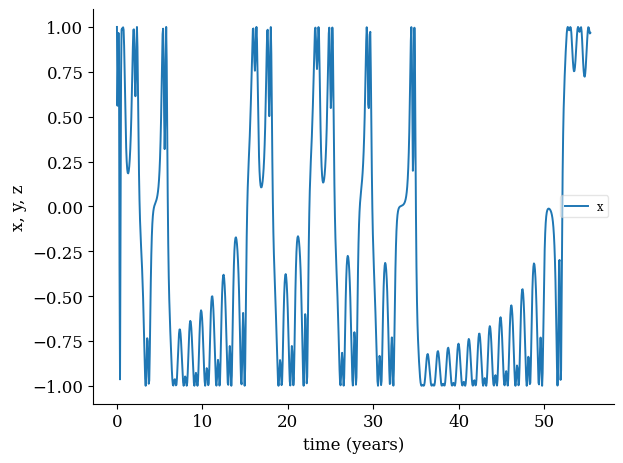

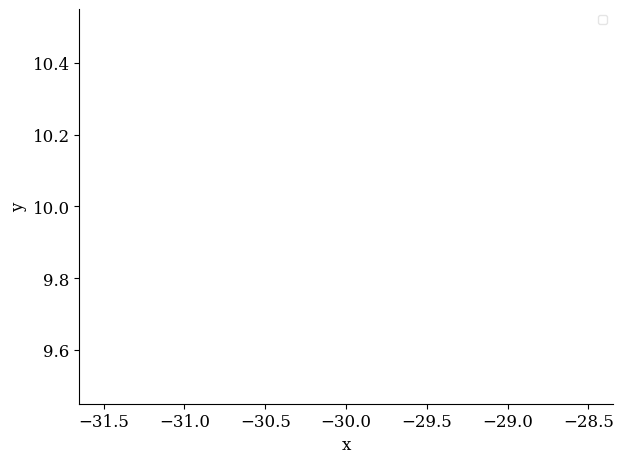

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(sol2.t, np.sin(np.pi * sol2.y[1] / 20), label="x")
# ax.plot(sol2.t, sol2.y[2], label="y")
# ax.plot(sol1.t, sol1.y[3], label="z")
ax.set_xlabel("time (years)")
ax.set_ylabel("x, y, z")
# ax.set_xlim(400, 500)
ax.legend()

fig, ax = plt.subplots(tight_layout=True)
ax.plot(sol1.y[1], sol1.y[2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()


Ciao